### Import libraries

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset
# transformers library from hugging face
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback 
import torch
import json
import os

os.environ["WANDB_DISABLED"] = "true"

### Random Seeds

In [4]:
import random
from transformers import set_seed

# Set the random seed for reproducibility
seed = 42  # You can use any integer value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
set_seed(seed)  # For transformers

### Load dataset

Condition
- 0: F2F
- 1: Online

In [5]:
# Transcript and prediction targets
video_path = "E:/GAR/videos"
df = {rnd: pd.read_csv(os.path.join(video_path, f"G4_{rnd}_tsrc_whisper.csv")) for rnd in ['R1', 'R2', 'R3']}

# Some F2F courses were mistakenly recorded as Online Courses
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Cotulla David Rodriguez Day 1 weather', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Jim Hogg Aaron Salazar Week 3 Day 1.mp4', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Kopperl Debbie Beavers', 'Condition'] = 0

### Define the functions

In [6]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predictions, average='weighted', zero_division=1)
    recall = recall_score(labels, predictions, average='weighted', zero_division=1)
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [7]:
from datasets import Dataset
import joblib

def tokenize_and_save(df, target, rnd, setting, video_path, results_dir, dataset_dir):
    
    # df = df[rnd]
    df = df[df['Condition'] == setting][['tsrc', target]]
    df = df.fillna(' ')

    # Encode the target column
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[target])
    
    # Save the label mapping to a JSON file
    label_mapping = {index: str(label) for index, label in enumerate(label_encoder.classes_)}
    mapping_file_path = os.path.join(results_dir, "encoded_to_original_label.json")
    with open(mapping_file_path, "w") as json_file:
        json.dump(label_mapping, json_file, indent=4)
    print(f"Label mapping saved to: {mapping_file_path}")
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    def tokenize_function(example):
        return tokenizer(example["tsrc"], truncation=True, padding="max_length", max_length=128)

    # Split dataset
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)
    
    for split, dataset in zip(["train", "val", "test"], [train_df, val_df, test_df]):
        dataset = Dataset.from_pandas(dataset)  # Convert DataFrame to Dataset
        dataset = dataset.map(tokenize_function, batched=True)  # Now `batched=True` works
        dataset = dataset.remove_columns(["tsrc"])
        dataset.set_format("numpy")
        joblib.dump(dataset, os.path.join(dataset_dir, f"{split}_dataset.joblib"))

    tokenizer.save_pretrained(results_dir)  # Save tokenizer
    
    return df

In [20]:
def training_evaluation(video_path, results_dir, output_dir, num_labels, label_mapping):
    
    # Load tokenized datasets
    train_dataset = joblib.load(os.path.join(dataset_dir, "train_dataset.joblib"))
    val_dataset = joblib.load(os.path.join(dataset_dir, "val_dataset.joblib"))
    test_dataset = joblib.load(os.path.join(dataset_dir, "test_dataset.joblib"))

    train_dataset = train_dataset.remove_columns(["__index_level_0__"])
    val_dataset = val_dataset.remove_columns(["__index_level_0__"])
    test_dataset = test_dataset.remove_columns(["__index_level_0__"])
    
    train_dataset.set_format("torch")
    val_dataset.set_format("torch")
    test_dataset.set_format("torch")
    # Define the Model
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",  # Perform evaluation after each epoch
        save_strategy="epoch",        # Save model after each epoch
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=30,
        weight_decay=0.01,
        logging_dir="./logs",
        save_total_limit=1,           # Keep only the best model
        load_best_model_at_end=True,  # Automatically load the best model
        metric_for_best_model="f1",   # Track f1 score for the best model
        greater_is_better=True,       # Higher metric is better
    )
    
    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )
    
    # Train the Model
    trainer.train()
    
    # Save the trained model and tokenizer
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model and tokenizer saved in: {output_dir}")
    
    # Evaluate on Test Set
    test_results = trainer.predict(test_dataset)
    predictions = np.argmax(test_results.predictions, axis=1)
    true_labels = test_results.label_ids
    
    # Get top-3 predictions
    top_n = 3
    sorted_indices = np.argsort(test_results.predictions, axis=1)[:, -top_n:][:, ::-1]
    
    def top_n_accuracy(true_labels, sorted_indices, n):
        binary_predictions = [1 if true_labels[i] in sorted_indices[i, :n] else 0 for i in range(len(true_labels))]
        return np.mean(binary_predictions)
    
    # Calculate metrics
    top1_accuracy = accuracy_score(true_labels, sorted_indices[:, 0])
    top1_precision = precision_score(true_labels, sorted_indices[:, 0], average="weighted", zero_division=1)
    top1_recall = recall_score(true_labels, sorted_indices[:, 0], average="weighted", zero_division=1)
    top1_f1 = f1_score(true_labels, sorted_indices[:, 0], average="weighted")
    top2_accuracy = top_n_accuracy(true_labels, sorted_indices, 2)
    top3_accuracy = top_n_accuracy(true_labels, sorted_indices, 3)

    # Confusion Matrix (for top-1 predictions)
    cm = confusion_matrix(true_labels, predictions)
    
    # Get the encoded labels that appear in the confusion matrix
    unique_labels = sorted(set(true_labels) | set(predictions))
    print(unique_labels)
    
    # Convert label indices back to original labels using label_mapping
    original_labels = [label_mapping[label] for label in unique_labels]
    print(original_labels)
    
    # Display and save the confusion matrix with original labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=original_labels)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"Confusion Matrix ({target} Top-1 Predictions)")
    
    cm_path = os.path.join(results_dir, f"confusion_matrix_{target}_top1.png")
    plt.savefig(cm_path)
    plt.show()
    plt.close()
    
    # Save metrics to JSON
    metrics = {
        "top1": {"accuracy": top1_accuracy, "precision": top1_precision, "recall": top1_recall, "f1": top1_f1},
        "top2": {"accuracy": top2_accuracy},
        "top3": {"accuracy": top3_accuracy},
    }
    with open(os.path.join(results_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    
    print("Evaluation Metrics:", metrics)




---------------------- Tokenize and save dataset R123, Setting 0, ESL Strategy ----------------------
Label mapping saved to: ./results0227_bert/R123/0/ESL Strategy\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.538410,0.442513,0.547912,0.442513,0.396819
2,1.642200,1.441103,0.474599,0.558582,0.474599,0.441362
3,1.642200,1.438774,0.489305,0.529465,0.489305,0.459622
4,1.074500,1.514195,0.502674,0.516109,0.502674,0.488712
5,1.074500,1.875747,0.502674,0.494335,0.502674,0.491821
6,0.534700,2.048412,0.510695,0.511794,0.510695,0.501482
7,0.534700,2.376740,0.516043,0.523051,0.516043,0.509575
8,0.290300,2.456027,0.521390,0.522759,0.521390,0.512523
9,0.202400,2.517375,0.522727,0.521618,0.522727,0.518263
10,0.202400,2.687199,0.517380,0.521630,0.517380,0.512657


Model and tokenizer saved in: ./models0227_bert/R123/0/ESL Strategy


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(9)]
['1', '2', '3', '4', '5', '6', '7', '9', '10']


<Figure size 1000x800 with 0 Axes>

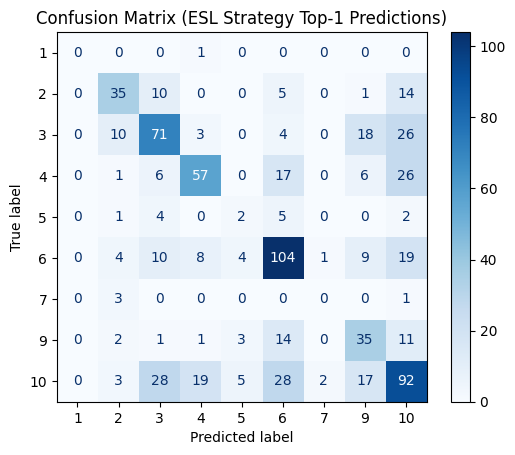

Evaluation Metrics: {'top1': {'accuracy': 0.5287049399198932, 'precision': 0.5342571603405806, 'recall': 0.5287049399198932, 'f1': 0.5284470756533248}, 'top2': {'accuracy': np.float64(0.719626168224299)}, 'top3': {'accuracy': np.float64(0.8117489986648865)}}



---------------------- Tokenize and save dataset R123, Setting 0, Curriculum ----------------------
Label mapping saved to: ./results0227_bert/R123/0/Curriculum\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.053682,0.993316,0.993360,0.993316,0.989984
2,0.072100,0.057156,0.993316,0.993360,0.993316,0.989984
3,0.072100,0.052032,0.993316,0.993360,0.993316,0.989984


Model and tokenizer saved in: ./models0227_bert/R123/0/Curriculum


[np.int64(2), np.int64(3)]
['4', '5']


<Figure size 1000x800 with 0 Axes>

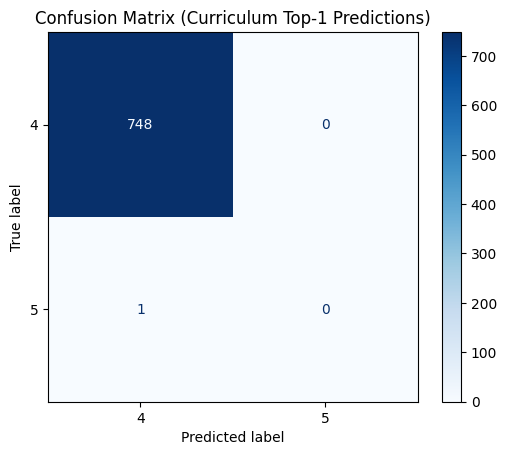

Evaluation Metrics: {'top1': {'accuracy': 0.9986648865153538, 'precision': 0.9986666690433706, 'recall': 0.9986648865153538, 'f1': 0.9979977757027183}, 'top2': {'accuracy': np.float64(0.9986648865153538)}, 'top3': {'accuracy': np.float64(0.9986648865153538)}}



---------------------- Tokenize and save dataset R123, Setting 0, Physical Group ----------------------
Label mapping saved to: ./results0227_bert/R123/0/Physical Group\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.004002,0.609626,0.603080,0.609626,0.546647
2,0.922900,1.042997,0.636364,0.635717,0.636364,0.561293
3,0.922900,1.252961,0.598930,0.601480,0.598930,0.582881
4,0.602800,1.437301,0.568182,0.618192,0.568182,0.579895
5,0.602800,1.643918,0.598930,0.610016,0.598930,0.587867
6,0.385500,1.722881,0.617647,0.567897,0.617647,0.564129
7,0.385500,1.912338,0.594920,0.569814,0.594920,0.570837


Model and tokenizer saved in: ./models0227_bert/R123/0/Physical Group


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
['1', '2', '3', '4', '5']


<Figure size 1000x800 with 0 Axes>

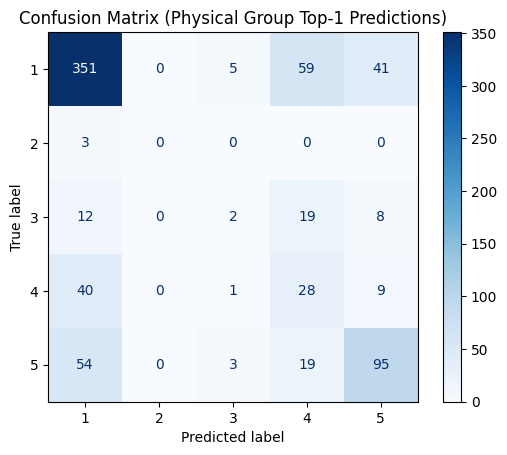

Evaluation Metrics: {'top1': {'accuracy': 0.6355140186915887, 'precision': 0.6435925796124663, 'recall': 0.6355140186915887, 'f1': 0.633399351427545}, 'top2': {'accuracy': np.float64(0.8024032042723631)}, 'top3': {'accuracy': np.float64(0.9012016021361816)}}



---------------------- Tokenize and save dataset R123, Setting 0, Activity Structure ----------------------
Label mapping saved to: ./results0227_bert/R123/0/Activity Structure\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.978634,0.364973,0.540783,0.364973,0.301811
2,2.073300,1.891321,0.402406,0.580614,0.402406,0.342634
3,2.073300,1.873758,0.415775,0.477638,0.415775,0.365173
4,1.410900,1.994990,0.398396,0.475667,0.398396,0.371428
5,1.410900,2.069461,0.418449,0.492111,0.418449,0.384059
6,0.917200,2.152183,0.427807,0.451925,0.427807,0.396223
7,0.917200,2.228806,0.421123,0.470222,0.421123,0.400204
8,0.600400,2.427521,0.413102,0.412932,0.413102,0.392114
9,0.401700,2.656255,0.422460,0.453938,0.422460,0.406648
10,0.401700,2.729683,0.411765,0.465993,0.411765,0.399678


Model and tokenizer saved in: ./models0227_bert/R123/0/Activity Structure


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(20)]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '18', '19', '21']


<Figure size 1000x800 with 0 Axes>

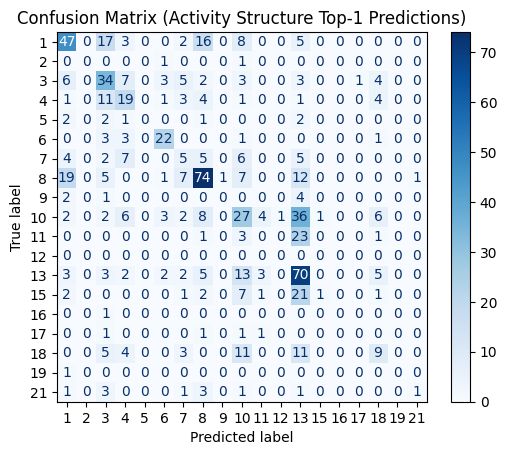

Evaluation Metrics: {'top1': {'accuracy': 0.41255006675567424, 'precision': 0.4167938255602838, 'recall': 0.41255006675567424, 'f1': 0.386949863887971}, 'top2': {'accuracy': np.float64(0.5887850467289719)}, 'top3': {'accuracy': np.float64(0.6835781041388518)}}



---------------------- Tokenize and save dataset R123, Setting 0, Mode ----------------------
Label mapping saved to: ./results0227_bert/R123/0/Mode\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.814592,0.410428,0.571572,0.410428,0.337016
2,1.797200,1.772766,0.439840,0.523272,0.439840,0.402810
3,1.797200,1.911287,0.387701,0.483454,0.387701,0.333223
4,1.272100,1.948572,0.429144,0.530734,0.429144,0.407835
5,1.272100,2.257648,0.435829,0.521051,0.435829,0.406587
6,0.821800,2.516336,0.419786,0.536475,0.419786,0.395597


Model and tokenizer saved in: ./models0227_bert/R123/0/Mode


[np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]
['1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '14', '15', '16', '17']


<Figure size 1000x800 with 0 Axes>

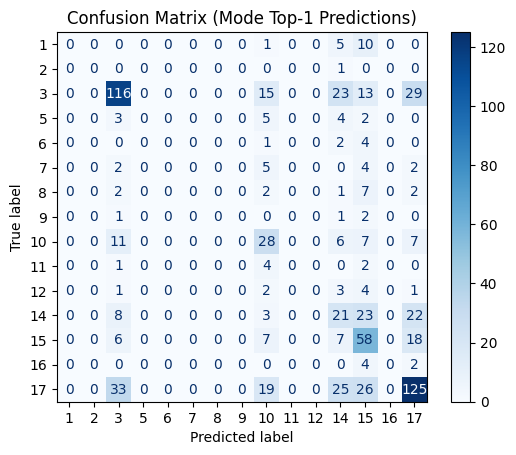

Evaluation Metrics: {'top1': {'accuracy': 0.46461949265687585, 'precision': 0.5626388142959916, 'recall': 0.46461949265687585, 'f1': 0.4448020218220897}, 'top2': {'accuracy': np.float64(0.6221628838451269)}, 'top3': {'accuracy': np.float64(0.7436582109479306)}}



---------------------- Tokenize and save dataset R123, Setting 0, Language Content ----------------------
Label mapping saved to: ./results0227_bert/R123/0/Language Content\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.414365,0.909091,0.917355,0.909091,0.865801
2,0.383700,0.423436,0.909091,0.917355,0.909091,0.865801
3,0.383700,0.414960,0.909091,0.900032,0.909091,0.891403
4,0.247800,0.474328,0.891711,0.891746,0.891711,0.880193
5,0.247800,0.566745,0.897059,0.882298,0.897059,0.883798


Model and tokenizer saved in: ./models0227_bert/R123/0/Language Content


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

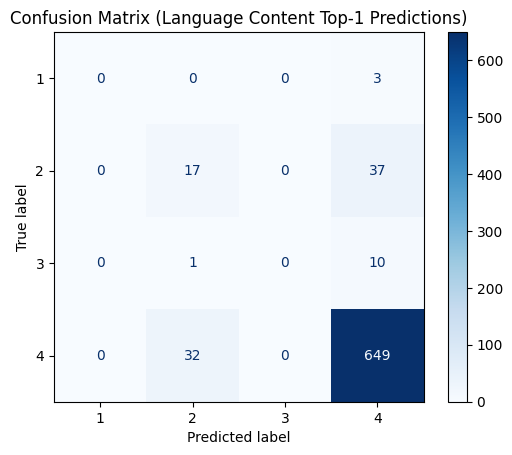

Evaluation Metrics: {'top1': {'accuracy': 0.8891855807743658, 'precision': 0.8873799114126417, 'recall': 0.8891855807743658, 'f1': 0.878756513701658}, 'top2': {'accuracy': np.float64(0.9746328437917223)}, 'top3': {'accuracy': np.float64(0.9946595460614153)}}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_bert/R123/0/Lang. of Instruction(T)\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.393084,0.879679,0.894156,0.879679,0.823370
2,0.294600,0.304073,0.883690,0.897272,0.883690,0.832887
3,0.294600,0.329659,0.863636,0.857288,0.863636,0.858889
4,0.197100,0.438610,0.879679,0.842633,0.879679,0.840821
5,0.197100,0.436102,0.879679,0.843568,0.879679,0.842617


Model and tokenizer saved in: ./models0227_bert/R123/0/Lang. of Instruction(T)


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

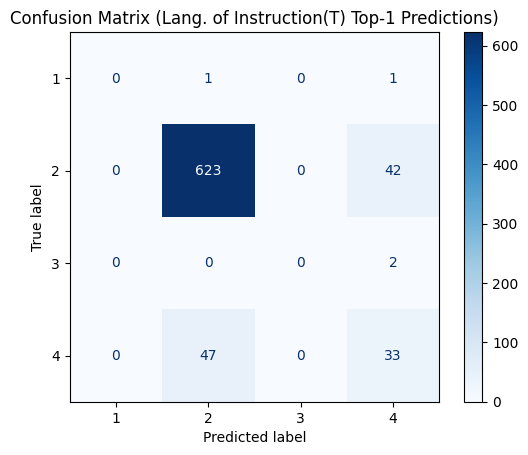

Evaluation Metrics: {'top1': {'accuracy': 0.8758344459279038, 'precision': 0.8748669746065181, 'recall': 0.8758344459279038, 'f1': 0.8726566319457553}, 'top2': {'accuracy': np.float64(0.9933244325767691)}, 'top3': {'accuracy': np.float64(0.9946595460614153)}}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_bert/R123/0/Lang. of Instruction(S)\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.577516,0.720588,0.707155,0.720588,0.702527
2,0.584500,0.606635,0.727273,0.735403,0.727273,0.729240
3,0.584500,0.827336,0.707219,0.732836,0.707219,0.713110
4,0.357600,1.037259,0.735294,0.726579,0.735294,0.726348


Model and tokenizer saved in: ./models0227_bert/R123/0/Lang. of Instruction(S)


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '4', '5']


<Figure size 1000x800 with 0 Axes>

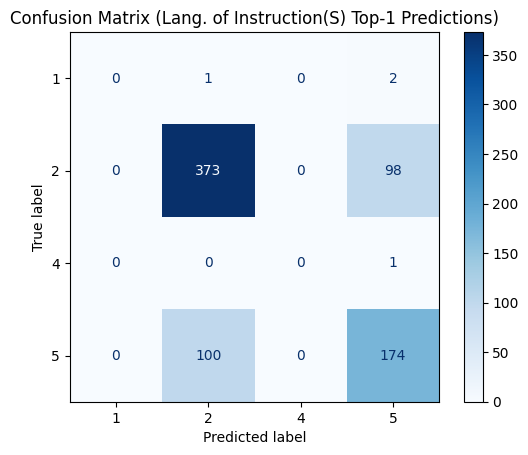

Evaluation Metrics: {'top1': {'accuracy': 0.7303070761014686, 'precision': 0.7316508854921253, 'recall': 0.7303070761014686, 'f1': 0.7283029814755176}, 'top2': {'accuracy': np.float64(0.9946595460614153)}, 'top3': {'accuracy': np.float64(0.9986648865153538)}}



---------------------- Tokenize and save dataset R123, Setting 1, ESL Strategy ----------------------
Label mapping saved to: ./results0227_bert/R123/1/ESL Strategy\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.560189,0.454212,0.593259,0.454212,0.393532
2,No log,1.440901,0.494505,0.570780,0.494505,0.453583
3,1.493800,1.457236,0.516484,0.586126,0.516484,0.486082
4,1.493800,1.631325,0.478022,0.500000,0.478022,0.461619
5,0.693000,1.898515,0.496337,0.507962,0.496337,0.476955


Model and tokenizer saved in: ./models0227_bert/R123/1/ESL Strategy


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
['1', '2', '3', '4', '5', '6', '7', '8', '9']


<Figure size 1000x800 with 0 Axes>

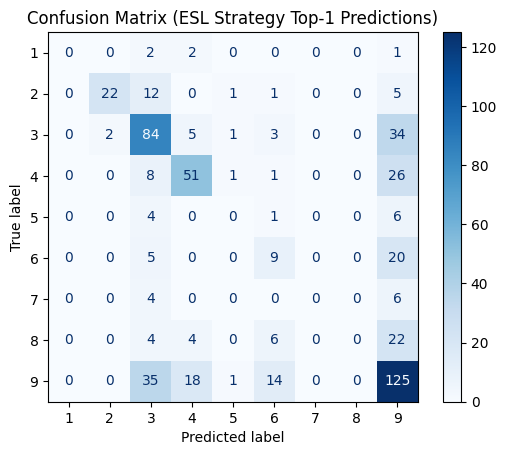

Evaluation Metrics: {'top1': {'accuracy': 0.532967032967033, 'precision': 0.585788199106786, 'recall': 0.532967032967033, 'f1': 0.504456315743013}, 'top2': {'accuracy': np.float64(0.7362637362637363)}, 'top3': {'accuracy': np.float64(0.8241758241758241)}}



---------------------- Tokenize and save dataset R123, Setting 1, Curriculum ----------------------
Label mapping saved to: ./results0227_bert/R123/1/Curriculum\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.114063,0.979853,0.980259,0.979853,0.969883
2,No log,0.112770,0.979853,0.980259,0.979853,0.969883
3,0.168200,0.125408,0.979853,0.980259,0.979853,0.969883


Model and tokenizer saved in: ./models0227_bert/R123/1/Curriculum


[np.int64(0), np.int64(3), np.int64(4)]
['1', '5', '13']


<Figure size 1000x800 with 0 Axes>

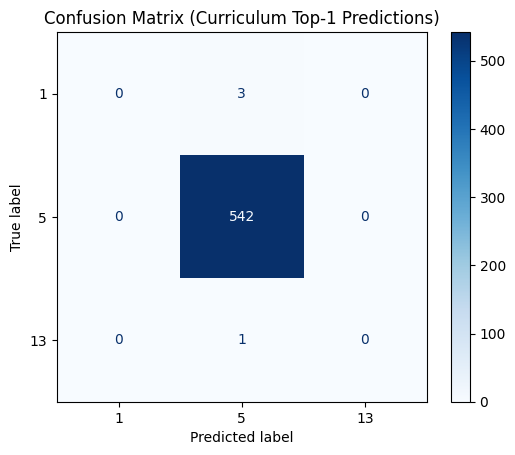

Evaluation Metrics: {'top1': {'accuracy': 0.9926739926739927, 'precision': 0.9927276630573334, 'recall': 0.9926739926739927, 'f1': 0.9890244559362207}, 'top2': {'accuracy': np.float64(0.9981684981684982)}, 'top3': {'accuracy': np.float64(0.9981684981684982)}}



---------------------- Tokenize and save dataset R123, Setting 1, Physical Group ----------------------
Label mapping saved to: ./results0227_bert/R123/1/Physical Group\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.691257,0.739927,0.750869,0.739927,0.716807
2,No log,0.684985,0.747253,0.758637,0.747253,0.710356
3,0.643800,0.807085,0.749084,0.756789,0.749084,0.720453
4,0.643800,1.296365,0.732601,0.732236,0.732601,0.692790
5,0.272500,1.361382,0.745421,0.723588,0.745421,0.716698


Model and tokenizer saved in: ./models0227_bert/R123/1/Physical Group


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

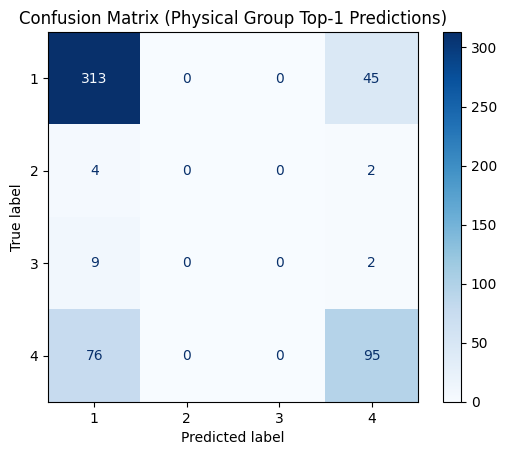

Evaluation Metrics: {'top1': {'accuracy': 0.7472527472527473, 'precision': 0.7482670211214988, 'recall': 0.7472527472527473, 'f1': 0.72897766394007}, 'top2': {'accuracy': np.float64(0.9358974358974359)}, 'top3': {'accuracy': np.float64(0.9578754578754579)}}



---------------------- Tokenize and save dataset R123, Setting 1, Activity Structure ----------------------
Label mapping saved to: ./results0227_bert/R123/1/Activity Structure\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.047999,0.386447,0.599594,0.386447,0.283652
2,No log,1.804731,0.478022,0.584954,0.478022,0.429492
3,2.033500,1.805901,0.465201,0.600377,0.465201,0.441692
4,2.033500,1.835141,0.465201,0.539631,0.465201,0.432205
5,1.114700,1.991590,0.467033,0.533511,0.467033,0.449655
6,1.114700,2.176966,0.437729,0.522205,0.437729,0.440235
7,1.114700,2.229041,0.467033,0.501764,0.467033,0.456187
8,0.526000,2.360550,0.463370,0.510072,0.463370,0.465170
9,0.526000,2.491107,0.461538,0.511172,0.461538,0.460426
10,0.254000,2.667050,0.443223,0.538369,0.443223,0.456161


Model and tokenizer saved in: ./models0227_bert/R123/1/Activity Structure


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']


<Figure size 1000x800 with 0 Axes>

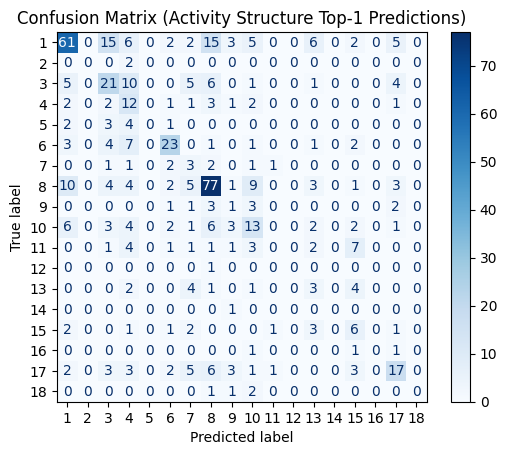

Evaluation Metrics: {'top1': {'accuracy': 0.4340659340659341, 'precision': 0.4916240174334269, 'recall': 0.4340659340659341, 'f1': 0.43626053502225104}, 'top2': {'accuracy': np.float64(0.5842490842490843)}, 'top3': {'accuracy': np.float64(0.6465201465201466)}}



---------------------- Tokenize and save dataset R123, Setting 1, Mode ----------------------
Label mapping saved to: ./results0227_bert/R123/1/Mode\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.636528,0.492674,0.661764,0.492674,0.402135
2,No log,1.608144,0.470696,0.599144,0.470696,0.393721
3,1.617000,1.589367,0.483516,0.479866,0.483516,0.427850
4,1.617000,1.845365,0.496337,0.492170,0.496337,0.445929
5,0.851500,2.004426,0.474359,0.508809,0.474359,0.448991
6,0.851500,2.311218,0.481685,0.520088,0.481685,0.444475
7,0.851500,2.596922,0.459707,0.475388,0.459707,0.444091


Model and tokenizer saved in: ./models0227_bert/R123/1/Mode


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
['1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']


<Figure size 1000x800 with 0 Axes>

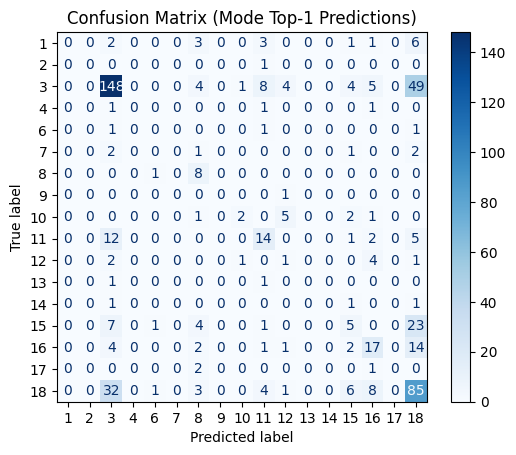

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Metrics: {'top1': {'accuracy': 0.5128205128205128, 'precision': 0.5536382787287042, 'recall': 0.5128205128205128, 'f1': 0.4931025733818193}, 'top2': {'accuracy': np.float64(0.6978021978021978)}, 'top3': {'accuracy': np.float64(0.7948717948717948)}}



---------------------- Tokenize and save dataset R123, Setting 1, Language Content ----------------------
Label mapping saved to: ./results0227_bert/R123/1/Language Content\encoded_to_original_label.json


C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.483180,0.844322,0.861809,0.844322,0.830092
2,No log,0.461717,0.851648,0.858089,0.851648,0.832468
3,0.488900,0.537873,0.860806,0.856639,0.860806,0.832787
4,0.488900,0.658133,0.849817,0.839618,0.849817,0.832624
5,0.229800,0.781330,0.858974,0.842193,0.858974,0.836899
6,0.229800,0.969292,0.822344,0.828553,0.822344,0.824743
7,0.229800,0.933222,0.847985,0.819679,0.847985,0.831145


Model and tokenizer saved in: ./models0227_bert/R123/1/Language Content


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

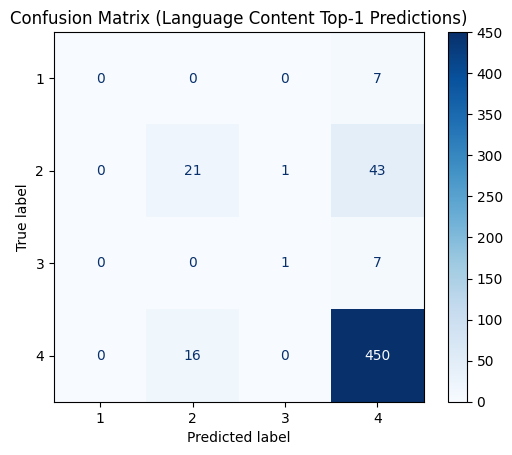

Evaluation Metrics: {'top1': {'accuracy': 0.8644688644688645, 'precision': 0.8452405848855553, 'recall': 0.8644688644688645, 'f1': 0.8413969461608661}, 'top2': {'accuracy': np.float64(0.9340659340659341)}, 'top3': {'accuracy': np.float64(0.9743589743589743)}}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_bert/R123/1/Lang. of Instruction(T)\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.330697,0.906593,0.899114,0.906593,0.892367
2,No log,0.286006,0.915751,0.910929,0.915751,0.903492
3,0.281900,0.383043,0.913919,0.911712,0.913919,0.904157
4,0.281900,0.392826,0.915751,0.914381,0.915751,0.908983
5,0.124000,0.420794,0.908425,0.908133,0.908425,0.905931
6,0.124000,0.527251,0.912088,0.902958,0.912088,0.905122


Model and tokenizer saved in: ./models0227_bert/R123/1/Lang. of Instruction(T)


[np.int64(0), np.int64(1), np.int64(3)]
['1', '2', '4']


<Figure size 1000x800 with 0 Axes>

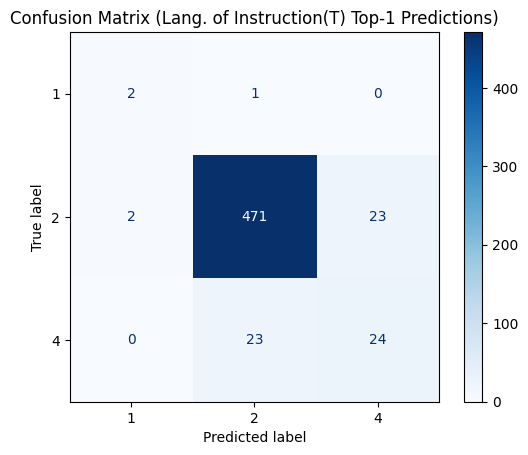

Evaluation Metrics: {'top1': {'accuracy': 0.9102564102564102, 'precision': 0.9110833610833611, 'recall': 0.9102564102564102, 'f1': 0.9106035956259396}, 'top2': {'accuracy': np.float64(0.9908424908424909)}, 'top3': {'accuracy': np.float64(1.0)}}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_bert/R123/1/Lang. of Instruction(S)\encoded_to_original_label.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.698794,0.673993,0.690816,0.673993,0.654988
2,No log,0.956581,0.633700,0.674606,0.633700,0.619225
3,0.619400,0.936323,0.686813,0.694194,0.686813,0.678498
4,0.619400,1.400136,0.690476,0.697361,0.690476,0.680987
5,0.261900,1.830503,0.672161,0.679735,0.672161,0.661625
6,0.261900,1.946217,0.695971,0.703018,0.695971,0.687467
7,0.261900,2.281068,0.666667,0.682729,0.666667,0.658485
8,0.095600,2.138116,0.683150,0.692390,0.683150,0.670835


Model and tokenizer saved in: ./models0227_bert/R123/1/Lang. of Instruction(S)


[np.int64(0), np.int64(1), np.int64(3)]
['1', '2', '5']


<Figure size 1000x800 with 0 Axes>

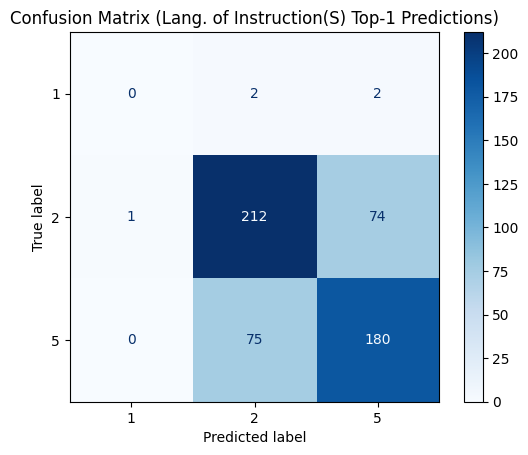

Evaluation Metrics: {'top1': {'accuracy': 0.717948717948718, 'precision': 0.7139738955536966, 'recall': 0.717948717948718, 'f1': 0.7159553816843446}, 'top2': {'accuracy': np.float64(0.9377289377289377)}, 'top3': {'accuracy': np.float64(0.9871794871794872)}}


In [21]:
data = list(df.keys())
settings = [0, 1]
y_cols = ['ESL Strategy', 'Curriculum', 'Physical Group',
          'Activity Structure', 'Mode', 'Language Content',
          'Lang. of Instruction(T)', 'Lang. of Instruction(S)']

df_merged = pd.concat([df['R1'], df['R2'], df['R3']])
df_merged = df_merged.reset_index(drop=True)


for rnd in ['R123']:
    for setting in settings:
        for target in y_cols:
            print(f"\n\n\n---------------------- Tokenize and save dataset {rnd}, Setting {setting}, {target} ----------------------")

            dataset_dir = f"./datasets0227_rf/{rnd}/{setting}/{target}"
            output_dir = f"./models0227_bert/{rnd}/{setting}/{target}"
            results_dir = f"./results0227_bert/{rnd}/{setting}/{target}"
            os.makedirs(dataset_dir, exist_ok=True)
            os.makedirs(output_dir, exist_ok=True)
            os.makedirs(results_dir, exist_ok=True)

                        
            label_encoder = LabelEncoder()
            df_merged["label"] = label_encoder.fit_transform(df_merged[target])
            
            # Save the label mapping to a JSON file
            label_mapping = {index: str(label) for index, label in enumerate(label_encoder.classes_)}
            mapping_file_path = os.path.join(results_dir, "encoded_to_original_label.json")
            with open(mapping_file_path, "w") as json_file:
                json.dump(label_mapping, json_file, indent=4)
            print(f"Label mapping saved to: {mapping_file_path}")

            num_labels = len(df_merged[target].unique())
            # tokenize_and_save(df_merged, target, rnd, setting, video_path, results_dir, dataset_dir)
            training_evaluation(video_path, results_dir, output_dir, num_labels, label_mapping)